In [2]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [ ]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'./genres/{g}'):
        songname = f'./genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

<Figure size 720x720 with 0 Axes>

In [2]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [3]:

file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    print('working on ' + g + '...')
    
    for filename in os.listdir(f'./genres/{g}'):
        songname = f'./genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rmse(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

working on blues...
working on classical...
working on country...
working on disco...
working on hiphop...
working on jazz...
working on metal...
working on pop...
working on reggae...
working on rock...


In [3]:
data = pd.read_csv('data.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.au,0.349943,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596742,121.557302,-19.158825,...,8.810668,-3.667367,5.751690,-5.162761,0.750947,-1.691937,-0.409954,-2.300208,1.219928,blues
1,blues.00001.au,0.340983,0.095918,1529.835316,2038.617579,3548.820207,0.056044,-207.556796,124.006717,8.930562,...,5.376802,-2.239119,4.216963,-6.012273,0.936109,-0.716537,0.293875,-0.287431,0.531573,blues
2,blues.00002.au,0.363603,0.175573,1552.481958,1747.165985,3040.514948,0.076301,-90.754394,140.459907,-29.109965,...,5.789265,-8.905224,-1.083720,-9.218359,2.455805,-7.726901,-1.815724,-3.433434,-2.226821,blues
3,blues.00003.au,0.404779,0.141191,1070.119953,1596.333948,2185.028454,0.033309,-199.431144,150.099218,5.647594,...,6.087676,-2.476420,-1.073890,-2.874777,0.780976,-3.316932,0.637981,-0.619690,-3.408233,blues
4,blues.00004.au,0.308590,0.091563,1835.494603,1748.362448,3580.945013,0.101500,-160.266031,126.198800,-35.605448,...,-2.806385,-6.934122,-7.558619,-9.173552,-4.512166,-5.453538,-0.924162,-4.409333,-11.703781,blues


In [4]:
data.shape

(1000, 28)

In [5]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

In [6]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [7]:
scaler = StandardScaler()
x = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [9]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               6912      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 48,714
Trainable params: 48,714
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_test, y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 204us/step - loss: 2.2561 - accuracy: 0.1725 - val_loss: 2.0636 - val_accuracy: 0.4300
Epoch 2/20
800/800 [==============================] - 0s 16us/step - loss: 1.9606 - accuracy: 0.3762 - val_loss: 1.7790 - val_accuracy: 0.4400
Epoch 3/20
800/800 [==============================] - 0s 17us/step - loss: 1.7163 - accuracy: 0.4100 - val_loss: 1.5966 - val_accuracy: 0.4700
Epoch 4/20
800/800 [==============================] - 0s 18us/step - loss: 1.5431 - accuracy: 0.4450 - val_loss: 1.4520 - val_accuracy: 0.4900
Epoch 5/20
800/800 [==============================] - 0s 19us/step - loss: 1.3837 - accuracy: 0.5387 - val_loss: 1.3567 - val_accuracy: 0.5300
Epoch 6/20
800/800 [==============================] - 0s 19us/step - loss: 1.2859 - accuracy: 0.5550 - val_loss: 1.2581 - val_accuracy: 0.5400
Epoch 7/20
800/800 [==============================] - 0s 18us/step - loss: 1.1998 - accuracy: 0

In [12]:
results = model.evaluate(x_test, y_test)

200/200 [==============================] - 0s 25us/step


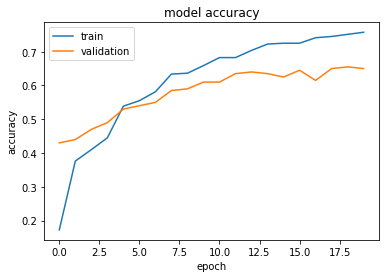

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

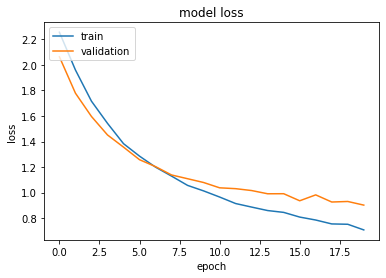

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
results

[0.9024174880981445, 0.6499999761581421]

In [16]:
predictions = model.predict(x_test)
np.argmax(predictions[0])

6

In [17]:
x_val = x_train[:200]
partial_x_train = x_train[200:]

y_val = y_train[:200]
partial_y_train = y_train[200:]

len(partial_y_train)

600

In [18]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=30,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 600 samples, validate on 200 samples
Epoch 1/30
600/600 [==============================] - 0s 201us/step - loss: 2.3009 - accuracy: 0.1550 - val_loss: 2.1924 - val_accuracy: 0.3150
Epoch 2/30
600/600 [==============================] - 0s 17us/step - loss: 2.1153 - accuracy: 0.3600 - val_loss: 2.0829 - val_accuracy: 0.3500
Epoch 3/30
600/600 [==============================] - 0s 19us/step - loss: 1.9772 - accuracy: 0.3950 - val_loss: 1.9656 - val_accuracy: 0.3700
Epoch 4/30
600/600 [==============================] - 0s 19us/step - loss: 1.8457 - accuracy: 0.4050 - val_loss: 1.8386 - val_accuracy: 0.3950
Epoch 5/30
600/600 [==============================] - 0s 18us/step - loss: 1.7121 - accuracy: 0.4333 - val_loss: 1.7130 - val_accuracy: 0.4100
Epoch 6/30
600/600 [==============================] - 0s 18us/step - loss: 1.5778 - accuracy: 0.4867 - val_loss: 1.5990 - val_accuracy: 0.4300
Epoch 7/30
600/600 [==============================] - 0s 21us/step - loss: 1.4530 - accuracy: 0

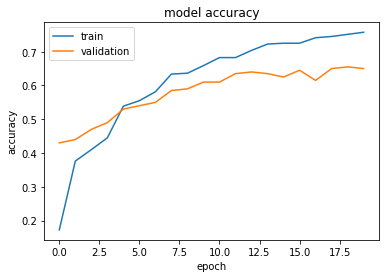

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

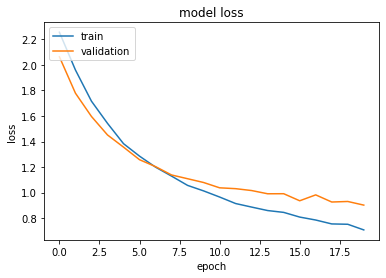

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
results = model.evaluate(x_test, y_test)

200/200 [==============================] - 0s 30us/step


In [23]:
results

[1.0447509098052978, 0.6299999952316284]